In [110]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19, densenet121
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from model import Chexnet
from dataset import MultiLabelDataset, ChestXRayCaptionDataset
from utils import evaluate_transform, quantize_probs, CONDITIONS
from tokenizer import create_tokenizer

# Fix kernel dying error on matplotlib
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [37]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# define a 1 image dataset
dataset = datasets.ImageFolder(root='gradcam_data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [38]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [39]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)
pred

In [43]:
pred

tensor([491])

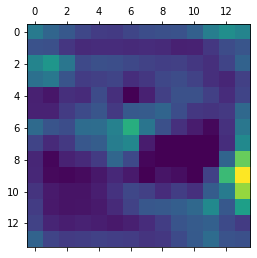

In [41]:
# get the gradient of the output with respect to the parameters of the model
vgg(img)[:, pred].backward()

# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [42]:
import cv2
img = cv2.imread('./gradcam_data/Elephant/1_oRpjlGC3sUy5yQJtpwclwg.jpeg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

In [25]:
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # get the pretrained DenseNet201 network
        self.densenet = densenet121(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.densenet.features
        
        # add the average global pool
        self.global_avg_pool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        # get the classifier of the vgg19
        self.classifier = self.densenet.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # don't forget the pooling
        x = self.global_avg_pool(x)
        x = x.view((1, 1024))
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [44]:
# initialize the VGG model
densenet = DenseNet()

# set the evaluation mode
densenet.eval()

# get the image from the dataloader
img, _ = next(iter(dataloader))

# get the most likely prediction of the model
pred = densenet(img).argmax(dim=1)
pred

tensor([981])

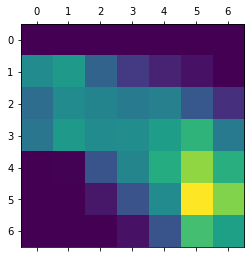

In [45]:
# get the gradient of the output with respect to the parameters of the model
densenet(img)[:, pred].backward()

# pull the gradients out of the model
gradients = densenet.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = densenet.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

In [47]:

img = cv2.imread('./gradcam_data/Elephant/1_oRpjlGC3sUy5yQJtpwclwg.jpeg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

In [33]:
superimposed_img

array([[[296. , 215. , 196. ],
        [296. , 215. , 196. ],
        [296. , 215. , 196. ],
        ...,
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ]],

       [[296. , 215. , 196. ],
        [296. , 215. , 196. ],
        [297. , 216. , 197. ],
        ...,
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ]],

       [[297. , 216. , 197. ],
        [297. , 216. , 197. ],
        [297. , 216. , 197. ],
        ...,
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ],
        [293.6, 201. , 188. ]],

       ...,

       [[126. , 112. , 102. ],
        [133. , 121. , 111. ],
        [161. , 151. , 138. ],
        ...,
        [114. ,  91. ,  84. ],
        [117. ,  95. ,  88. ],
        [108. ,  85. ,  80. ]],

       [[127. , 115. , 105. ],
        [145. , 134. , 124. ],
        [157. , 149. , 136. ],
        ...,
        [121. ,  97. ,  92. ],
        [116. ,  92. ,  87. ],
        [120. ,

In [2]:
checkpoint = torch.load('weights/pretrained_encoder/pretrained_enc_epoch_5_2022-03-08_15-43-47.540586.pth.tar')
print(f"loaded epoch {checkpoint['epoch']+1} model, val_loss: {checkpoint['val_loss']}")
encoder = Chexnet()
encoder.load_state_dict(checkpoint['encoder'].state_dict())


loaded epoch 5 model, val_loss: 0.28202417492866516
loading pretrained weights..


<All keys matched successfully>

In [3]:
rand = torch.rand(1, 3, 256, 256).cuda()
encoder.true_densenet(rand)

tensor([[[[-3.9531e-04,  9.1961e-05, -9.2621e-05,  ..., -1.0640e-05,
           -1.1390e-04,  7.1917e-05],
          [ 2.5455e-05,  2.2342e-05, -1.3341e-05,  ...,  2.9697e-06,
           -6.4486e-05,  1.2914e-04],
          [ 1.2597e-04,  8.4570e-06, -5.3558e-05,  ...,  9.4185e-05,
            1.0576e-04,  4.1226e-05],
          ...,
          [-2.4513e-06, -7.2222e-05, -5.1184e-05,  ...,  7.2043e-05,
            5.5737e-05,  8.4292e-05],
          [ 5.9107e-05, -1.7456e-04, -5.1275e-05,  ...,  1.7200e-05,
           -9.1793e-05, -7.5613e-05],
          [-1.5947e-04, -2.2903e-05, -1.0158e-04,  ..., -3.1761e-05,
           -1.1300e-04,  5.5208e-05]],

         [[-9.4766e-04, -1.7225e-03, -2.9804e-03,  ...,  1.3714e-04,
           -1.0265e-03, -7.5887e-04],
          [-4.2995e-04, -3.1495e-06,  1.0778e-03,  ..., -2.4821e-04,
           -7.2684e-04, -1.5884e-03],
          [ 2.4719e-04,  1.4392e-03,  2.1875e-04,  ...,  1.0636e-03,
            5.7608e-04, -1.7371e-03],
          ...,
     

In [113]:
captionloader = data.DataLoader(
    ChestXRayCaptionDataset('val', transform=transforms.ToTensor()),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

dataloader = data.DataLoader(
    MultiLabelDataset('val', transform=evaluate_transform),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

dataloader_no_transform = data.DataLoader(
    MultiLabelDataset('val', transform=transforms.ToTensor()),
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

In [111]:
tokenizer = create_tokenizer()

2091lines [00:00, 174276.48lines/s]


['no evidence of consolidation to suggest pneumonia is seen . there is some retrocardiac atelectasis . a small left pleural effusion may be present . no pneumothorax is seen . no pulmonary edema . a right granuloma is unchanged . the heart is mildly enlarged unchanged . there is tortuosity of the aorta .']

In [5]:
encoder.eval()

tensor([[1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0.]])

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Pleural Other', 'Fracture', 'No Finding']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
['no evidence of consolidation to suggest pneumonia is seen . there is some retrocardiac atelectasis . a small left pleural effusion may be present . no pneumothorax is seen . no pulmonary edema . a right granuloma is unchanged . the heart is mildly enlarged unchanged . there is tortuosity of the aorta .']


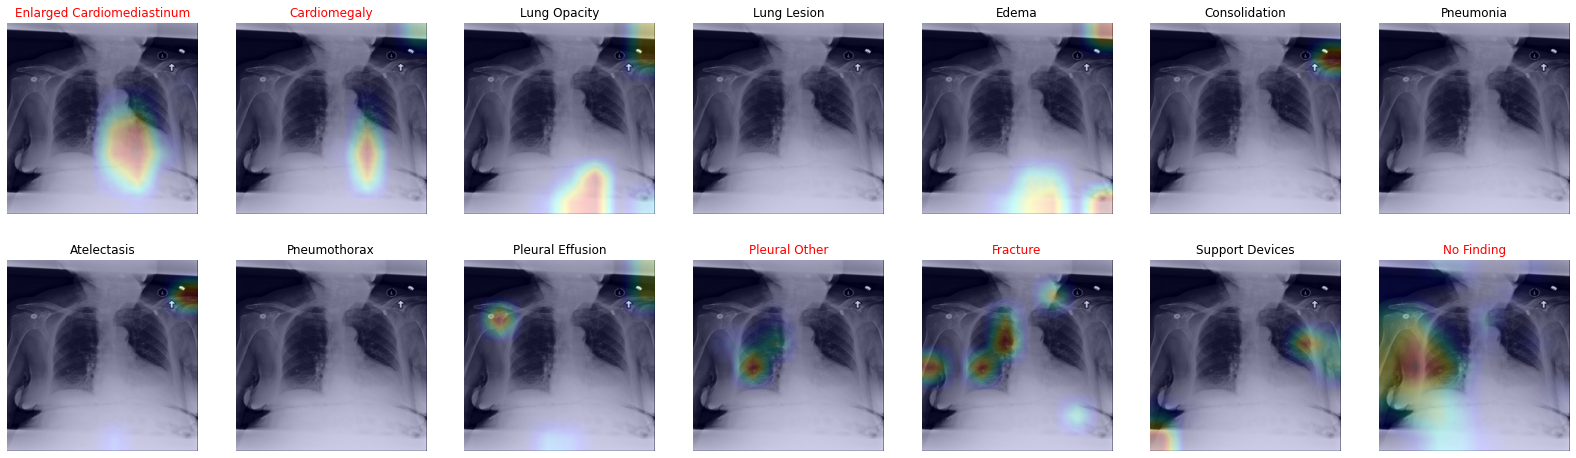

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
['no evidence of consolidation to suggest pneumonia is seen . there is some retrocardiac atelectasis . a small left pleural effusion may be present . no pneumothorax is seen . no pulmonary edema . a right granuloma is unchanged . the heart is mildly enlarged unchanged . there is tortuosity of the aorta .']


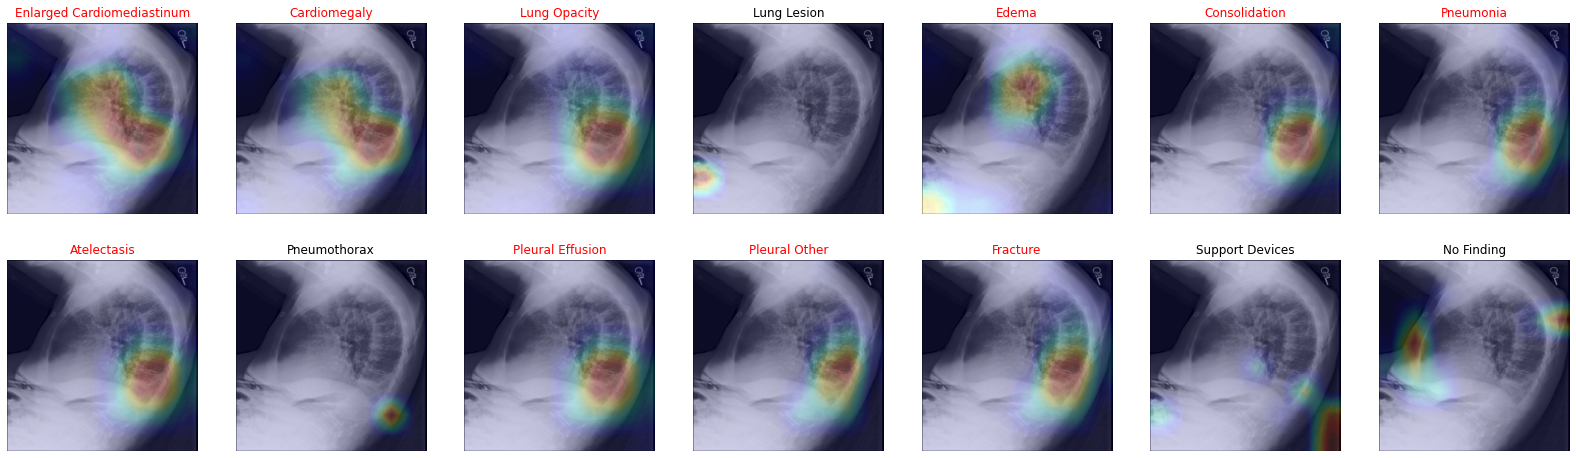

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Fracture']
['there are moderate bilateral pleural effusions with overlying atelectasis underlying consolidation not excluded . mild prominence of the interstitial markings suggests mild pulmonary edema . the cardiac silhouette is mildly enlarged . the mediastinal contours are unremarkable . there is no evidence of pneumothorax .']


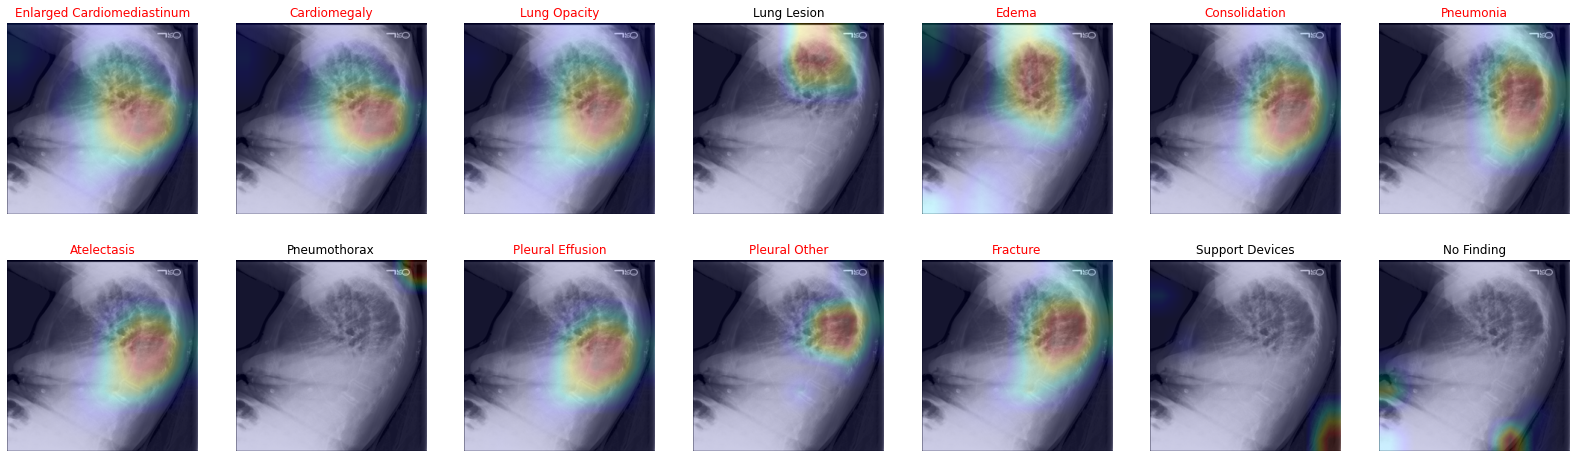

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
['there are moderate bilateral pleural effusions with overlying atelectasis underlying consolidation not excluded . mild prominence of the interstitial markings suggests mild pulmonary edema . the cardiac silhouette is mildly enlarged . the mediastinal contours are unremarkable . there is no evidence of pneumothorax .']


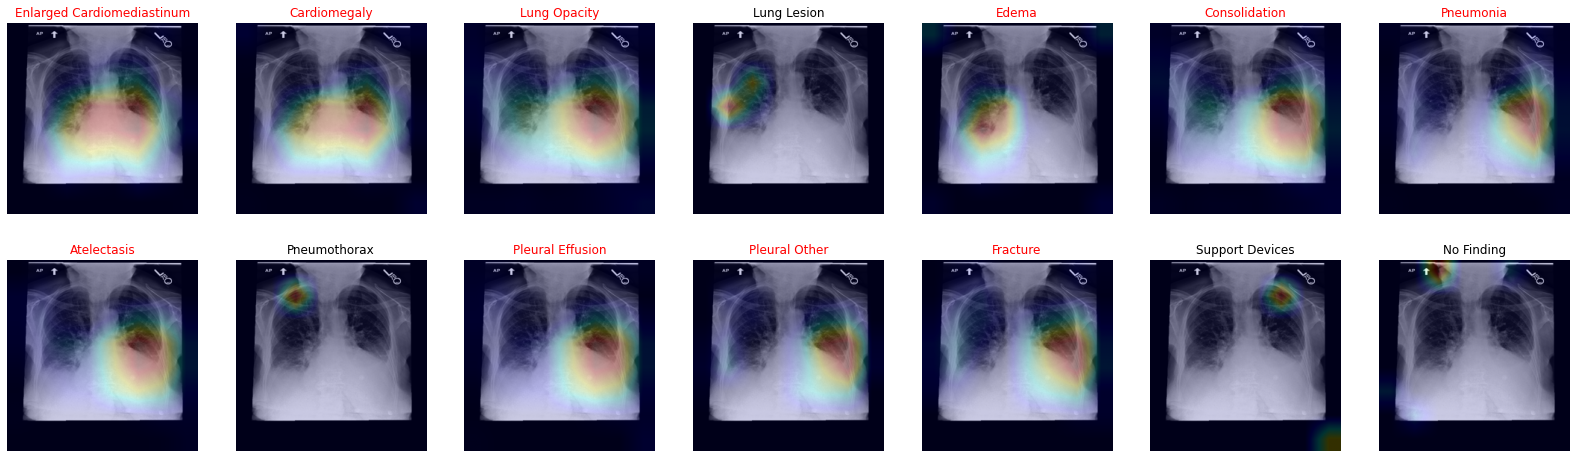

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Fracture']
['moderate to large bilateral pleural effusions are again seen right greater than left . there is suspected superimposed pulmonary edema may have slightly improved since prior although detailed evaluation is limited given layering pleural effusions . vasculature appears less engorged . cardiac silhouette cannot be .']


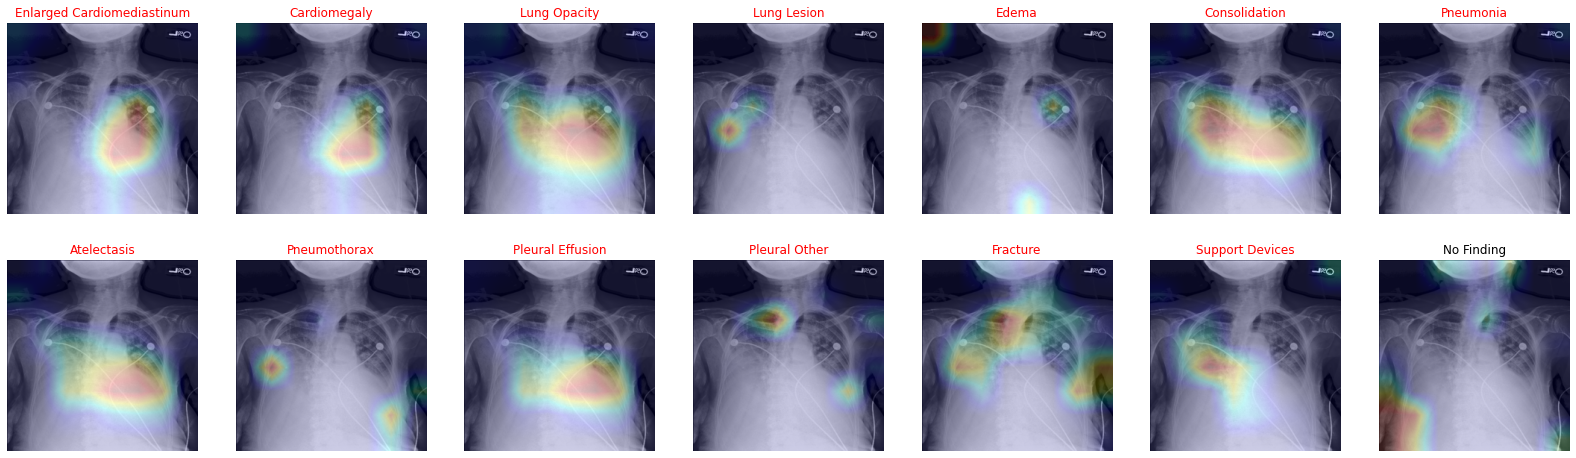

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Fracture']
['heart size is difficult to assess given the presence of moderate to large bilateral pleural effusions but appears at moderately enlarged . the mediastinal contours are grossly unremarkable . perihilar haziness with vascular indistinctness and diffuse alveolar opacities are compatible with moderate pulmonary edema . bibasilar compressive atelectasis is demonstrated . no pneumothorax is seen . moderate multilevel degenerative changes are noted in the thoracic spine .']


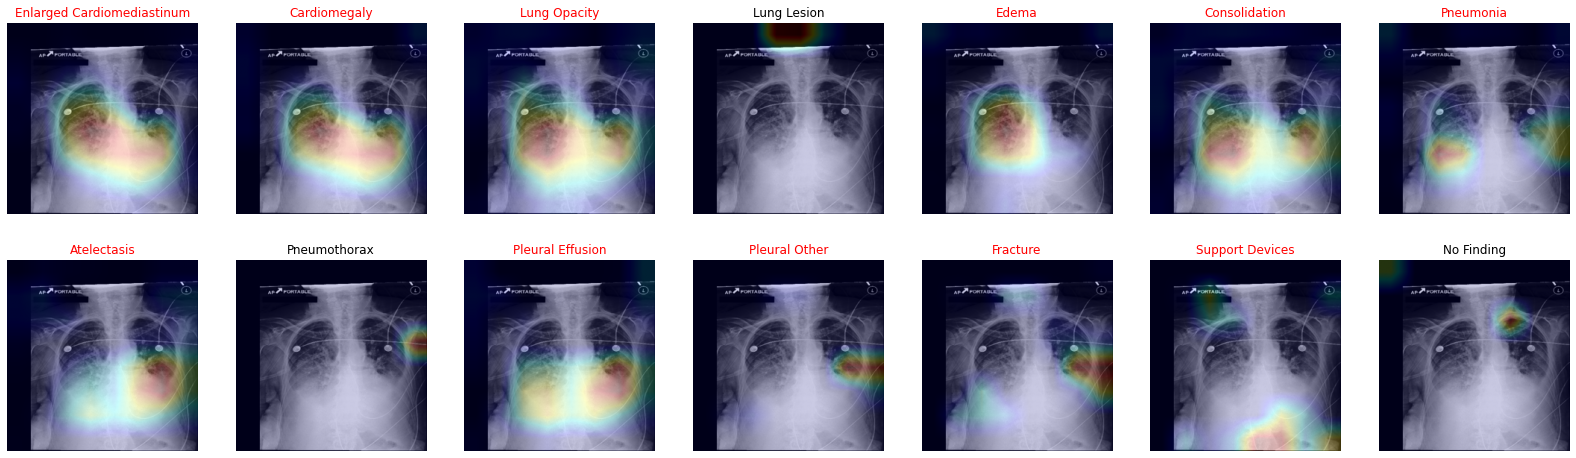

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Atelectasis', 'Pleural Effusion', 'Fracture']
['the bilateral pleural effusions lower lobe volume loss and dense lower lobe opacity compatible with a combination of volume . the heart continues to be moderately enlarged . there is mild vascular redistribution .']


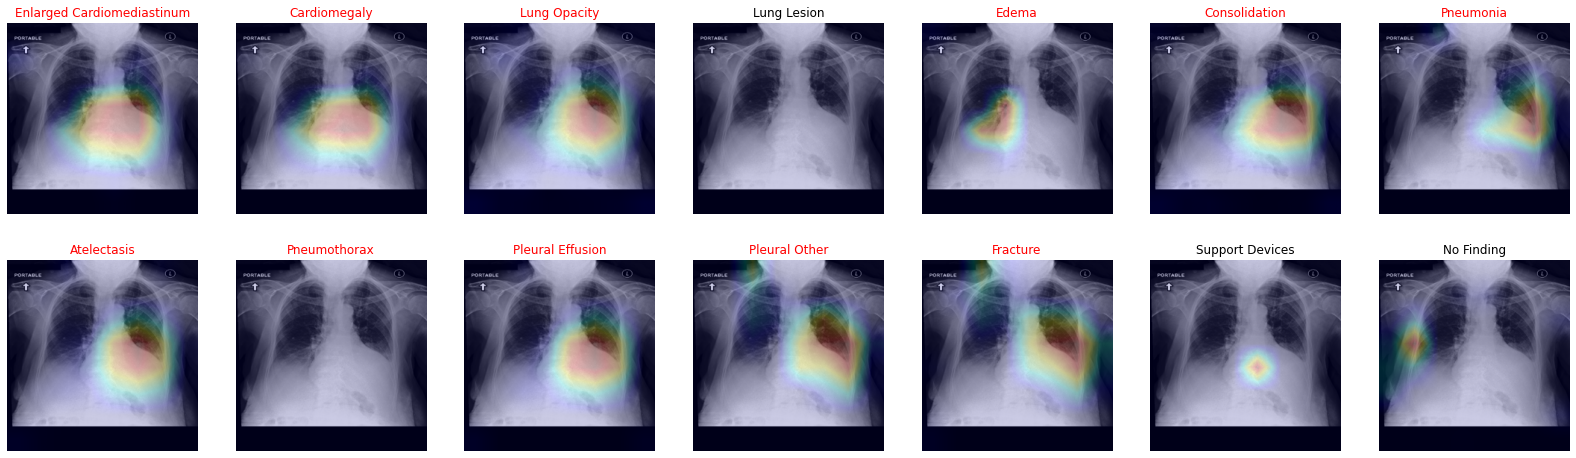

Predicted:	
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
True:		
['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pleural Effusion', 'Pleural Other', 'Fracture']
['frontal and lateral views of the chest . size of the bilateral effusions left greater than right has slightly decreased in size since prior ex . there is less pulmonary vascular congestion on the ex as well . cardiac silhouette which appears enlarged is unchanged . no acute osseous abnormality is .']


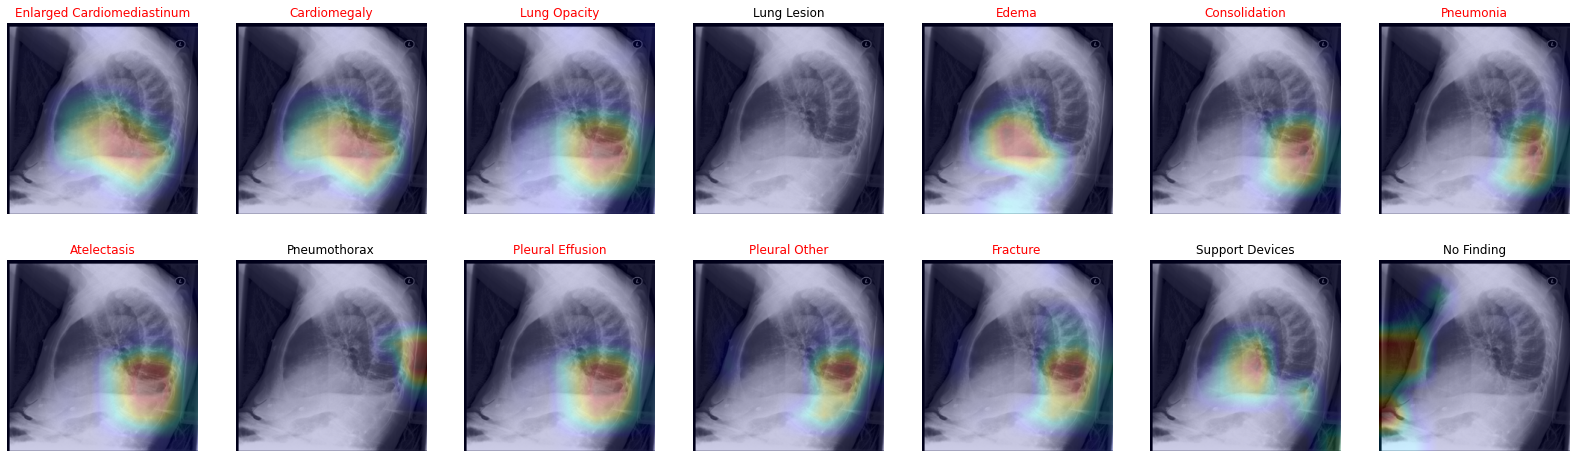

In [193]:
# get the image from the dataloader
for nth_image in range(8):
    img = next(iter(dataloader))[0][nth_image,:,:,:].reshape(1, 3, 256, 256).cuda()

    # get the most likely prediction of the model
    _, pred = encoder(img)
    # print(f"Raw: {pred}")
    quantized = quantize_probs(pred.cpu().detach().numpy())[0]
    print(f"Predicted:\t")
    print([CONDITIONS[i] for i in range(len(CONDITIONS)) if quantized[i] == 1])

    true_label = next(iter(dataloader))[1][nth_image]
    print(f"True:\t\t")
    print([CONDITIONS[i] for i in range(len(CONDITIONS)) if true_label[i] == 1])

    caption = tokenizer.decode(next(iter(captionloader))[1][nth_image].unsqueeze(0))
    print(caption)

    img_to_show = next(iter(dataloader_no_transform))[0][nth_image,:,:,:].reshape(1, 3, 256, 256).cuda()
    img_to_show = img_to_show.cpu().reshape(3, 256, 256).permute(1, 2, 0).numpy()

    plt.figure(figsize=(28, 8))
    for to_inspect in range(14):
        # print(f"Heatmap for {CONDITIONS[to_inspect]}")

        # get the gradient of the output with respect to the parameters of the model
        pred[:, to_inspect].backward(retain_graph=True)

        # pull the gradients out of the model
        gradients = encoder.get_activations_gradient()

        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        # get the activations of the last convolutional layer
        activations = encoder.get_activations(img).detach()

        # weight the channels by corresponding gradients
        for i in range(1024):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()

        # relu on top of the heatmap
        # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
        heatmap = torch.relu(heatmap)

        # normalize the heatmap
        heatmap /= torch.max(heatmap)

        # draw the heatmap
        # plt.matshow(heatmap.cpu().squeeze())
        # plt.show()

        heatmap = cv2.resize(heatmap.cpu().numpy(), (256, 256))
        heatmap = np.uint8(255 * heatmap)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

        superimposed_img = heatmap[:,:,::-1] * 0.2 + (img_to_show * 255 * 0.8)
        plt.subplot(2, 7, to_inspect+1)

        plt.title(CONDITIONS[to_inspect], fontdict={'color': 'red' if quantized[to_inspect] == 1 else 'black'})
        plt.axis('off')
        plt.imshow(superimposed_img / 255)
    plt.show()